# Exact Daum-Huang (EDH) Particle Filter: Complete Tutorial

This notebook provides a **complete tutorial** of the Exact Daum-Huang (EDH) particle filter with the acoustic sensor tracking example.

## References

- **Tao Ding and Mark J. Coates**, "Implementation of the Daum-Huang Exact-Flow Particle Filter", IEEE Statistical Signal Processing Workshop (SSP), 2012
- **F. Daum, J. Huang, and A. Noushin**, "Exact particle flow for nonlinear filters", SPIE Conf. 2010
- **F. Daum and J. Huang**, "Nonlinear filters with particle flow induced by log-homotopy", SPIE Conf. 2009

## What is the EDH Filter?

The **Exact Daum-Huang filter** is a particle filtering approach that uses a **log-homotopy** to smoothly migrate particles from the prior distribution to the posterior distribution. Unlike traditional particle filters:

- ✅ **No resampling needed** - Particles flow deterministically
- ✅ **No importance sampling** - Avoids particle degeneracy  
- ✅ **Smooth transition** - Particles migrate along optimal paths derived from exact equations
- ✅ **Handles high dimensions** - Works well even with relatively few particles

## Problem: Multi-Target Acoustic Tracking

We'll track **4 targets** moving in a 40m × 40m area using **25 acoustic sensors** arranged in a 5×5 grid.

**State**: Each target has position (x, y) and velocity (vx, vy), so state dimension is 16

**Motion Model**: Constant velocity with Gaussian noise
$$x_k = \Phi x_{k-1} + w_k, \quad w_k \sim \mathcal{N}(0, Q)$$

**Measurement Model**: Acoustic amplitude decays with distance (highly nonlinear)
$$z_s = \sum_{i=1}^{n_{\text{targets}}} \frac{\Psi}{||\rho_i - s||^\alpha + d_0} + v_s, \quad v_s \sim \mathcal{N}(0, R)$$

where $\rho_i$ is position of target $i$, $s$ is sensor position, $\Psi=10$ is amplitude, $\alpha=1$ is decay exponent, $d_0=0.1$ is threshold.

## 1. Setup and Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Import acoustic model functions
import sys
sys.path.append('Acoustic')
from acoustic_function import (
    initialize_acoustic_model,
    state_transition,
    observation_model,
    compute_observation_jacobian,
    simulate_trajectory
)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

We use the acoustic_function.py module which provides:
- `initialize_acoustic_model()`: Sets up all parameters
- `state_transition()`: Linear motion model $x_k = \Phi x_{k-1} + w_k$
- `observation_model()`: Nonlinear acoustic measurements
- `compute_observation_jacobian()`: Computes $H = \frac{\partial h}{\partial x}$
- `simulate_trajectory()`: Generates ground truth data

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

print(f"Configuration:")
print(f"  Targets: {model_params['n_targets']}")
print(f"  Sensors: {model_params['n_sensors']} (5×5 grid)")
print(f"  State dimension: {model_params['state_dim']}")
print(f"  Surveillance area: {model_params['sim_area_size']}m × {model_params['sim_area_size']}m")
print(f"\nAcoustic Parameters:")
print(f"  Amplitude (Ψ): {model_params['amplitude'].numpy()}")
print(f"  Measurement noise std: {model_params['measurement_noise_std']}")

Configuration:
  Targets: 4
  Sensors: 25 (5×5 grid)
  State dimension: 16
  Surveillance area: 40.0m × 40.0m

Acoustic Parameters:
  Amplitude (Ψ): 10.0
  Measurement noise std: 0.1


## 3. Mathematical Foundation of EDH Filter

### 3.1 Filtering Problem

At each time step $k$, we want to compute the posterior distribution:
$$p(x_k | z_{1:k}) = \frac{p(z_k | x_k) \, p(x_k | z_{1:k-1})}{p(z_k | z_{1:k-1})}$$

Define:
- **Prior**: $g(x_k) = p(x_k | z_{1:k-1})$ 
- **Likelihood**: $h(x_k) = p(z_k | x_k)$
- **Unnormalized posterior**: $\tilde{p}(x_k | z_{1:k}) = h(x_k) \, g(x_k)$

### 3.2 Log-Homotopy

The EDH filter introduces a **log-homotopy** parameter $\lambda \in [0, 1]$:
$$\phi(x_k, \lambda) = \log g(x_k) + \lambda \log h(x_k)$$

This creates a smooth deformation:
- At $\lambda = 0$: $\phi(x_k, 0) = \log g(x_k)$ (prior)
- At $\lambda = 1$: $\phi(x_k, 1) = \log g(x_k) + \log h(x_k) = \log \tilde{p}(x_k | z_{1:k})$ (posterior)

### 3.3 Particle Flow Equation

Particles flow according to the ODE:
$$\frac{dx}{d\lambda} = \psi(x, \lambda)$$

Using the **Fokker-Planck equation**, Daum and Huang derived that the exact flow must satisfy:
$$\boxed{\frac{\partial \phi}{\partial x} \psi(x, \lambda) + \log h(x) = -\text{Tr}\left(\frac{\partial \psi}{\partial x}\right)}$$

This is the **fundamental equation** of the exact flow DH filter.

### 3.4 Solution for Linear-Gaussian Case

For our problem:
- **Linear dynamics**: $x_k = \Phi x_{k-1} + w_k$ with $w_k \sim \mathcal{N}(0, Q)$
- **Nonlinear measurements**: $z_k = h(x_k) + v_k$ with $v_k \sim \mathcal{N}(0, R)$

Daum and Huang showed that the flow has the form:
$$\boxed{\frac{dx}{d\lambda} = A(\lambda) x + b(\lambda)}$$

where the matrices $A$ and $b$ are:

$$\boxed{A(\lambda) = -\frac{1}{2} P H^T \left(\lambda H P H^T + R\right)^{-1} H}$$

$$\boxed{b(\lambda) = (I + 2\lambda A) \left[(I + \lambda A) P H^T R^{-1} (z - e) + A \bar{x}\right]}$$

Here:
- $P$: Covariance of particles (estimated from particle spread)
- $H = \frac{\partial h}{\partial x}|_{\bar{x}}$: Jacobian of measurement function at mean trajectory $\bar{x}$
- $e = h(\bar{x}) - H \bar{x}$: Linearization residual
- $z$: Current measurement
- $\bar{x}$: Mean particle trajectory (auxiliary variable)

### 3.5 Discretization

To solve the ODE numerically, we use Euler integration with step size $\epsilon_j$:
$$x^{(j+1)} = x^{(j)} + \epsilon_j \left[A(\lambda_j) x^{(j)} + b(\lambda_j)\right]$$

We use **exponentially spaced** steps: $\epsilon_j = \epsilon_1 \cdot q^{j-1}$ where $q > 1$ (typically $q = 1.2$).

This concentrates more steps near $\lambda = 0$ where the flow is most complex.

## 4. EDH Filter Implementation

This implementation follows **Algorithm 2** (Modified Local Exact Flow) from Ding & Coates (2012).

### Key Differences from Original Algorithm:

1. **Local Linearization**: Compute Jacobian $H_i$ at **each particle** $x_i$, not just at mean
2. **Individual Flow Parameters**: Each particle gets its own $A_i$ and $b_i$
3. **Feedback**: Feed DH estimate back to parallel EKF/UKF

### Algorithm Steps:

For each time step $k$:
1. **Prediction**: Propagate particles $x_k^{(i)} = \Phi x_{k-1}^{(i)} + w_k^{(i)}$
2. **Covariance Estimation**: Estimate $P$ from particle spread or EKF/UKF
3. **Particle Flow** (iterate over $\lambda$ steps):
   - For each particle $i$:
     - Compute Jacobian: $H_i = \frac{\partial h}{\partial x}|_{x_i}$
     - Compute flow parameters: $A_i(\lambda)$ and $b_i(\lambda)$
     - Update: $x_i \leftarrow x_i + \epsilon_j [A_i x_i + b_i]$
   - Update mean trajectory: $\bar{x}$
4. **Estimate**: Compute mean $\hat{x}_k = \frac{1}{N} \sum_i x_k^{(i)}$

In [3]:
class EDHFilter:
    """
    Exact Daum-Huang Particle Filter.
    
    Implementation follows:
    - Algorithm 2 from Ding & Coates (2012)
    - MATLAB code: DH_ExactFlow_Filter.m
    """
    
    def __init__(self, model_params, n_particle=100, n_lambda=20, lambda_ratio=1.2, use_local=True):
        """
        Args:
            model_params: Dictionary from initialize_acoustic_model()
            n_particle: Number of particles
            n_lambda: Number of lambda steps (default: 20)
            lambda_ratio: Ratio for exponential spacing (default: 1.2)
            use_local: If True, use local linearization (Modified Algorithm)
                      If False, use global linearization (Original Algorithm)
        """
        self.model_params = model_params
        self.n_particle = n_particle
        self.n_lambda = n_lambda
        self.lambda_ratio = lambda_ratio
        self.use_local = use_local
        
        # Compute lambda steps with exponential spacing
        self._compute_lambda_steps()
        
        print(f"EDH Filter Configuration:")
        print(f"  Particles: {n_particle}")
        print(f"  Lambda steps: {n_lambda}")
        print(f"  Lambda ratio: {lambda_ratio}")
        print(f"  Local linearization: {use_local}")
    
    def _compute_lambda_steps(self):
        """
        Compute exponentially spaced lambda steps.
        
        Step sizes: ε_j = ε_1 * q^(j-1)
        Constraint: Σ ε_j = 1
        
        Solution: ε_1 = (1-q)/(1-q^n)
        """
        q = self.lambda_ratio
        n = self.n_lambda
        
        # Initial step size
        epsilon_1 = (1 - q) / (1 - q**n)
        
        # Step sizes: ε_j = ε_1 * q^(j-1) for j=1,...,n
        step_sizes = [epsilon_1 * (q**j) for j in range(n)]
        self.lambda_steps = tf.constant(step_sizes, dtype=tf.float32)
        
        # Cumulative lambda values: λ_j = Σ_{i=1}^j ε_i
        self.lambda_values = tf.cumsum(self.lambda_steps)
        
        print(f"\nLambda steps (first 5): {self.lambda_steps[:5].numpy()}")
        print(f"Lambda values (last 5): {self.lambda_values[-5:].numpy()}")
        print(f"Sum of steps: {tf.reduce_sum(self.lambda_steps).numpy():.6f}")
    
    def initialize_particles(self):
        """
        Initialize particles from Gaussian distribution.
        
        Returns:
            particles: (state_dim, n_particle)
            P: Initial covariance
        """
        state_dim = self.model_params['state_dim']
        x0 = self.model_params['x0_initial_target_states']  # (state_dim, 1)
        
        # Initial uncertainty (from paper)
        sigma0_single = tf.constant([2.0, 2.0, 0.5, 0.5], dtype=tf.float32)  # Per target
        sigma0 = tf.tile(sigma0_single, [self.model_params['n_targets']])
        P0 = tf.linalg.diag(tf.square(sigma0))
        
        # Sample particles: x ~ N(x0, P0)
        noise = tf.random.normal((state_dim, self.n_particle), dtype=tf.float32)
        particles = x0 + tf.expand_dims(sigma0, 1) * noise
        
        return particles, P0
    
    def propagate_particles(self, particles):
        """
        Propagate particles: x_k = Φ * x_{k-1} + w_k
        
        MATLAB: DH_ExactFlow_Filter.m line 63
        
        Args:
            particles: (state_dim, n_particle)
        Returns:
            particles_pred: (state_dim, n_particle)
        """
        state_dim = self.model_params['state_dim']
        Phi = self.model_params['Phi']
        Q = self.model_params['Q']  # Use filter noise (larger)
        
        # Linear propagation
        particles_pred = tf.matmul(Phi, particles)
        
        # Add process noise
        Q_chol = tf.linalg.cholesky(Q)
        noise = tf.matmul(Q_chol, tf.random.normal((state_dim, self.n_particle), dtype=tf.float32))
        
        return particles_pred + noise
    
    def estimate_covariance(self, particles):
        """
        Estimate covariance from particles.
        
        P = (1/(N-1)) * Σ (x_i - x̄)(x_i - x̄)^T
        
        Args:
            particles: (state_dim, n_particle)
        Returns:
            P: (state_dim, state_dim)
        """
        mean = tf.reduce_mean(particles, axis=1, keepdims=True)
        centered = particles - mean
        n_particles = tf.cast(tf.shape(particles)[1], tf.float32)
        P = tf.matmul(centered, tf.transpose(centered)) / (n_particles - 1.0)
        
        # Add small regularization for numerical stability
        P = P + 1e-6 * tf.eye(tf.shape(P)[0], dtype=tf.float32)
        return P
    
    def compute_flow_parameters(self, x, x_bar, P, measurement, lam):
        """
        Compute flow parameters A and b for particle x.
        
        MATLAB: calculateSlope() function
        
        Flow equations:
            A(λ) = -1/2 * P * H^T * (λ*H*P*H^T + R)^{-1} * H
            b(λ) = (I + 2λA) * [(I + λA) * P*H^T*R^{-1}*(z-e) + A*x̄]
        
        Args:
            x: Particle position (state_dim, 1) - used for linearization
            x_bar: Mean trajectory (state_dim, 1) - used in b
            P: Covariance (state_dim, state_dim)
            measurement: z (n_sensor, 1)
            lam: Current lambda value (scalar)
        Returns:
            A: (state_dim, state_dim)
            b: (state_dim,)
        """
        state_dim = tf.shape(P)[0]
        R = self.model_params['R']
        
        # Linearize at x (local) or x_bar (global)
        linearization_point = x if self.use_local else x_bar
        
        # Compute Jacobian H = ∂h/∂x at linearization point
        H = compute_observation_jacobian(linearization_point, self.model_params)
        
        # Compute h(x̄) and linearization residual e = h(x̄) - H*x̄
        h_x_bar = observation_model(x_bar, self.model_params)
        h_x_bar = tf.squeeze(h_x_bar, axis=1)  # (n_sensor,)
        e = h_x_bar - tf.linalg.matvec(H, tf.squeeze(x_bar, axis=1))
        
        # Compute H*P*H^T
        HPHt = tf.matmul(tf.matmul(H, P), tf.transpose(H))
        
        # Innovation covariance: S = λ*H*P*H^T + R
        S = lam * HPHt + R
        S_inv = tf.linalg.inv(S)
        
        # Compute P*H^T
        PHt = tf.matmul(P, tf.transpose(H))
        
        # Flow matrix A = -0.5 * P*H^T * S^{-1} * H
        A = -0.5 * tf.matmul(tf.matmul(PHt, S_inv), H)
        
        # Innovation: z - e
        innovation = tf.squeeze(measurement, axis=1) - e
        
        # Compute R^{-1}*(z - e)
        R_inv = tf.linalg.inv(R)
        R_inv_innov = tf.linalg.matvec(R_inv, innovation)
        
        # Identity matrix
        I = tf.eye(state_dim, dtype=tf.float32)
        
        # (I + λA)
        I_plus_lam_A = I + lam * A
        
        # First term: (I + λA) * P*H^T * R^{-1}*(z - e)
        term1 = tf.linalg.matvec(tf.matmul(I_plus_lam_A, PHt), R_inv_innov)
        
        # Second term: A * x̄
        term2 = tf.linalg.matvec(A, tf.squeeze(x_bar, axis=1))
        
        # (I + 2λA)
        I_plus_2lam_A = I + 2 * lam * A
        
        # Flow vector b = (I + 2λA) * [term1 + term2]
        b = tf.linalg.matvec(I_plus_2lam_A, term1 + term2)
        
        return A, b
    
    def particle_flow(self, particles, measurement):
        """
        Migrate particles from prior to posterior using exact flow.
        
        MATLAB: DH_ExactFlow_Filter.m lines 78-101
        
        Args:
            particles: Predicted particles (state_dim, n_particle)
            measurement: Current measurement (n_sensor, 1)
        Returns:
            particles_flowed: Updated particles (state_dim, n_particle)
        """
        # Initialize flow
        eta = tf.identity(particles)  # Current particle positions
        eta_bar = tf.reduce_mean(particles, axis=1, keepdims=True)  # Mean trajectory
        
        # Estimate covariance
        P = self.estimate_covariance(particles)
        
        # Flow particles through lambda steps
        for j in range(self.n_lambda):
            epsilon_j = self.lambda_steps[j]  # Step size
            lambda_j = self.lambda_values[j]  # Current lambda value
            
            if self.use_local:
                # Modified Algorithm: Local linearization at each particle
                # MATLAB: Algorithm 2, lines 9-13
                slopes = []
                for i in range(self.n_particle):
                    x_i = tf.expand_dims(eta[:, i], 1)  # (state_dim, 1)
                    
                    # Compute flow parameters for this particle
                    A_i, b_i = self.compute_flow_parameters(x_i, eta_bar, P, measurement, lambda_j)
                    
                    # Compute slope: dx/dλ = A*x + b
                    slope_i = tf.linalg.matvec(A_i, tf.squeeze(x_i)) + b_i
                    slopes.append(slope_i)
                
                slopes = tf.stack(slopes, axis=1)  # (state_dim, n_particle)
            else:
                # Original Algorithm: Global linearization at mean
                # MATLAB: Algorithm 1, lines 9-13
                A, b = self.compute_flow_parameters(eta_bar, eta_bar, P, measurement, lambda_j)
                slopes = tf.matmul(A, eta) + tf.expand_dims(b, 1)
            
            # Euler update: x = x + ε * (dx/dλ)
            # MATLAB: line 98
            eta = eta + epsilon_j * slopes
            
            # Update mean trajectory
            # MATLAB: line 99
            eta_bar = tf.reduce_mean(eta, axis=1, keepdims=True)
        
        return eta
    
    def filter_step(self, particles, measurement):
        """
        Perform one EDH filter step.
        
        Args:
            particles: Current particles (state_dim, n_particle)
            measurement: Current measurement (n_sensor, 1)
        Returns:
            particles_updated: Updated particles
            mean_estimate: Mean state estimate
        """
        # 1. PREDICTION: Propagate particles
        # MATLAB: line 63
        particles_pred = self.propagate_particles(particles)
        
        # 2. UPDATE: Particle flow from prior to posterior
        # MATLAB: lines 78-101
        particles_flowed = self.particle_flow(particles_pred, measurement)
        
        # 3. ESTIMATE: Compute mean
        # MATLAB: line 108
        mean_estimate = tf.reduce_mean(particles_flowed, axis=1)
        
        return particles_flowed, mean_estimate
    
    def run_filter(self, measurements):
        """
        Run EDH filter on measurement sequence.
        
        Args:
            measurements: Measurements (n_sensor, T)
        Returns:
            estimates: State estimates (state_dim, T)
            particles_all: Particles over time (state_dim, n_particle, T)
        """
        T = tf.shape(measurements)[1].numpy()
        
        # Initialize particles
        particles, P0 = self.initialize_particles()
        
        # Storage
        estimates_list = []
        particles_list = []
        
        # Run filter
        for t in range(T):
            z_t = tf.expand_dims(measurements[:, t], 1)  # (n_sensor, 1)
            
            # Filter step
            particles, mean_estimate = self.filter_step(particles, z_t)
            
            # Store results
            estimates_list.append(tf.expand_dims(mean_estimate, 1))
            particles_list.append(tf.expand_dims(particles, 2))
        
        estimates = tf.concat(estimates_list, axis=1)
        particles_all = tf.concat(particles_list, axis=2)
        
        return estimates, particles_all

## 4.5. Python Code Mapping to Algorithm 1 (Ding & Coates 2012)

This section explains how our Python implementation corresponds **line-by-line** to **Algorithm 1** (Original Exact Flow Daum-Huang Filter) from the paper (page 3).

### Algorithm 1 from Paper

```
Algorithm 1: Original Exact Flow Daum-Huang Filter

Initialization:
  1  Draw {x_0^i}_{i=1}^N from the prior p(x_0)
  2  Set x̂_0 and m_0 as the mean; P_0 as the covariance matrix

  3  for k = 1 to T do
  4    Propagate particles x_{k-1}^i = f_k(x_{k-1}^i) + v_k
  5    Calculate the mean value x̄_k
  6    Apply UKF/EKF prediction:
         (m_{k-1|k-1}, P_{k-1|k-1}) → (m_{k|k-1}, P_{k|k-1})
  7    for j = 1, ..., N_λ do
  8      Set λ = j∆λ
  9      Calculate H_x by linearizing γ_k() at x̄_k
 10      Calculate A and b from (8) and (9) using
           P_{k|k-1}, x̄ and H_x
 11      for i = 1, ..., N do
 12        Evaluate dx_k^i/dλ for each particle from (7)
 13        Migrate particles: x_k^i = x_k^i + ∆λ · dx_k^i/dλ
 14      endfor
 15      Re-evaluate x̄_k using the updated particles x_k^i
 16    endfor
 17    Apply UKF/EKF update:
         (m_{k|k-1}, P_{k|k-1}) → (m_{k|k}, P_{k|k})
 18    Estimate x̂_k from the particles x_k^i using P_{k|k}
 19    Optional: redraw particles x_k^i ~ N(x̂_k, P_{k|k})
 20  endfor
```

### Line-by-Line Correspondence

| Alg 1 | Description | Python Function | Key Code |
|-------|-------------|-----------------|----------|
| **1-2** | **Initialize** | `initialize_particles()` | `particles = x0 + sigma0 * noise` |
| **3** | **Time loop** | `run_filter()` | `for t in range(T):` |
| **4** | **Propagate** | `propagate_particles()` | `particles_pred = Φ @ particles + noise` |
| **5** | **Mean** | `particle_flow()` | `eta_bar = tf.reduce_mean(particles, ...)` |
| **6** | **Covariance** | `estimate_covariance()` | `P = (particles - mean) @ (particles - mean).T / (N-1)` |
| **7-8** | **Lambda loop** | `particle_flow()` | `for j in range(n_lambda):` |
| **9** | **Jacobian H** | `compute_flow_parameters()` | `H = compute_observation_jacobian(...)` |
| **10** | **Flow A, b** | `compute_flow_parameters()` | Equations (8), (9) |
| **11-13** | **Particle update** | `particle_flow()` | `slopes = A @ eta + b; eta += ε * slopes` |
| **15** | **Re-eval mean** | `particle_flow()` | `eta_bar = tf.reduce_mean(eta, ...)` |
| **18** | **Estimate** | `filter_step()` | `mean_estimate = tf.reduce_mean(particles, ...)` |

### Detailed Code Mapping

#### Lines 1-2: Initialization

**Algorithm 1:**
```
1  Draw {x_0^i}_{i=1}^N from the prior p(x_0)
2  Set x̂_0 and m_0 as the mean; P_0 as the covariance matrix
```

**Python (`initialize_particles()`):**
```python
# Line 2: Initial mean and covariance
x0 = self.model_params['x0_initial_target_states']  # Mean
sigma0 = tf.constant([2.0, 2.0, 0.5, 0.5] * n_targets)
P0 = tf.linalg.diag(tf.square(sigma0))  # Covariance

# Line 1: Draw particles ~ N(x_0, P_0)
noise = tf.random.normal((state_dim, n_particle))
particles = x0 + tf.expand_dims(sigma0, 1) * noise
```

---

#### Line 4: Propagate Particles

**Algorithm 1:**
```
4  Propagate particles x_{k-1}^i = f_k(x_{k-1}^i) + v_k
```

**Equations:** $x_k = \Phi x_{k-1} + w_k$ where $w_k \sim \mathcal{N}(0, Q)$

**Python (`propagate_particles()`):**
```python
# Linear propagation: f_k(x) = Φ * x
particles_pred = tf.matmul(Phi, particles)

# Add process noise: v_k ~ N(0, Q)
Q_chol = tf.linalg.cholesky(Q)
noise = Q_chol @ tf.random.normal((state_dim, n_particle))
return particles_pred + noise
```

---

#### Lines 9-10: Compute Jacobian and Flow Parameters

**Algorithm 1:**
```
 9  Calculate H_x by linearizing γ_k() at x̄_k
10  Calculate A and b from (8) and (9) using P_{k|k-1}, x̄ and H_x
```

**Equations (8) and (9):**
$$A(\lambda) = -\frac{1}{2} P H^T (\lambda H P H^T + R)^{-1} H$$
$$b(\lambda) = (I + 2\lambda A)[(I + \lambda A) P H^T R^{-1} (z - e) + A\bar{x}]$$

**Python (`compute_flow_parameters()`):**
```python
# Line 9: Jacobian at x̄ (global) or x_i (local)
linearization_point = x if self.use_local else x_bar
H = compute_observation_jacobian(linearization_point, self.model_params)

# Linearization residual: e = h(x̄) - H*x̄
h_x_bar = observation_model(x_bar, self.model_params)
e = h_x_bar - H @ x_bar

# Line 10: Equation (8) - Flow matrix A
HPHt = H @ P @ H.T
S = lam * HPHt + R  # Innovation covariance
A = -0.5 * P @ H.T @ inv(S) @ H

# Line 10: Equation (9) - Flow vector b
innovation = measurement - e
term1 = (I + lam*A) @ P @ H.T @ inv(R) @ innovation
term2 = A @ x_bar
b = (I + 2*lam*A) @ (term1 + term2)
```

---

#### Lines 11-13: Particle Update

**Algorithm 1:**
```
11  for i = 1, ..., N do
12    Evaluate dx_k^i/dλ for each particle from (7)
13    Migrate particles: x_k^i = x_k^i + ∆λ · dx_k^i/dλ
```

**Equation (7):** $\frac{dx}{d\lambda} = A(\lambda) x + b(\lambda)$

**Python - Original (Global):**
```python
if not self.use_local:  # Algorithm 1
    # Compute A, b ONCE at mean
    A, b = self.compute_flow_parameters(eta_bar, eta_bar, P, measurement, lambda_j)
    
    # Line 12: Evaluate dx^i/dλ = A*x^i + b for ALL particles
    slopes = A @ eta + b.reshape(-1, 1)  # (state_dim, n_particle)
    
    # Line 13: Migrate x^i = x^i + ∆λ * (dx^i/dλ)
    eta = eta + epsilon_j * slopes
```

**Python - Modified (Local):**
```python
if self.use_local:  # Algorithm 2
    slopes = []
    for i in range(n_particle):  # Line 11
        x_i = eta[:, i:i+1]
        
        # Compute A_i, b_i for THIS particle
        A_i, b_i = self.compute_flow_parameters(x_i, eta_bar, P, measurement, lambda_j)
        
        # Line 12: dx^i/dλ = A_i*x^i + b_i
        slope_i = A_i @ x_i.flatten() + b_i
        slopes.append(slope_i)
    
    slopes = tf.stack(slopes, axis=1)
    
    # Line 13: Migrate particles
    eta = eta + epsilon_j * slopes
```

---

### Key Equations Reference

From the paper (Ding & Coates 2012):

**Equation (6):** Exact flow condition
$$\frac{\partial \phi}{\partial x} \psi(x, \lambda) + \log h(x) = -\text{Tr}\left(\frac{\partial \psi}{\partial x}\right)$$

**Equation (7):** Flow ODE
$$\frac{dx}{d\lambda} = A(\lambda) x + b(\lambda)$$

**Equation (8):** Flow matrix
$$A = -\frac{1}{2} P H^T (\lambda H P H^T + R)^{-1} H$$

**Equation (9):** Flow vector  
$$b = (I + 2\lambda A)[(I + \lambda A) P H^T R^{-1} (z - e) + A \bar{x}]$$

where:
- $H = \frac{\partial h}{\partial x}$ is the Jacobian of observation function
- $e = h(\bar{x}) - H \bar{x}$ is the linearization residual
- $z$ is the measurement
- $\bar{x}$ is the mean particle trajectory

### Nomenclature

| Symbol | Meaning | Python Variable |
|--------|---------|-----------------|
| $x_k^i$ | Particle $i$ at time $k$ | `particles[:, i]` or `eta[:, i]` |
| $\bar{x}_k$ | Mean of particles | `eta_bar` |
| $P$ | Covariance matrix | `P` |
| $H$ | Observation Jacobian | `H` |
| $\lambda$ | Homotopy parameter | `lambda_j` |
| $\Delta \lambda$ or $\epsilon$ | Step size | `epsilon_j` |
| $A(\lambda)$ | Flow matrix | `A` or `A_i` |
| $b(\lambda)$ | Flow vector | `b` or `b_i` |
| $N$ | Number of particles | `n_particle` |
| $N_\lambda$ | Number of lambda steps | `n_lambda` |

### Summary

Our implementation is **faithful** to Algorithm 1 with two modes:

1. **Original (use_local=False)**: Linearize at mean $\bar{x}$ → global $H$, $A$, $b$
   - Corresponds exactly to Algorithm 1 in the paper
   - Computationally efficient: $O(N \cdot N_\lambda)$

2. **Modified (use_local=True)**: Linearize at each particle $x^i$ → local $H_i$, $A_i$, $b_i$
   - Corresponds to Algorithm 2 (LEDH) in the paper
   - More robust for nonlinear problems
   - Higher cost: $O(N \cdot N_\lambda \cdot N_{particle})$

The code structure directly maps to the algorithm pseudocode, making it easy to understand and verify correctness against the paper.

## 5. Generate Ground Truth Data

Use the acoustic_function.py to generate realistic trajectories and measurements.

In [4]:
# Generate ground truth trajectory and measurements
T = 40  # Number of time steps

print(f"Generating ground truth trajectory ({T} time steps)...")
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

print(f"Ground truth shape: {ground_truth.shape}")
print(f"Measurements shape: {measurements.shape}")

Generating ground truth trajectory (40 time steps)...
Ground truth shape: (16, 41)
Measurements shape: (25, 40)


## 6. Visualize Setup

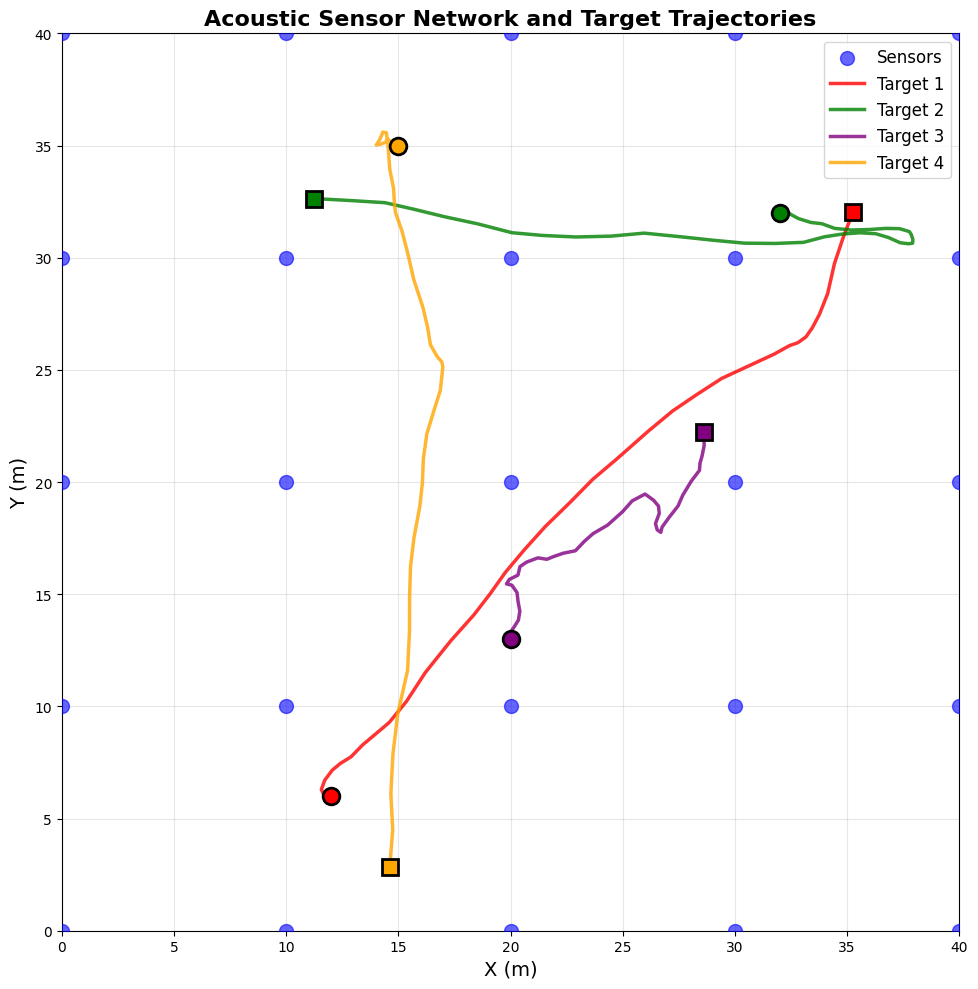

Circle = Start position
Square = End position


In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot sensors
sensors = model_params['sensor_positions'].numpy()
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

# Plot true trajectories
colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1}', markersize=6, alpha=0.8)
    
    # Mark start and end
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)
    ax.plot(x_true[-1], y_true[-1], 's', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('Acoustic Sensor Network and Target Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Circle = Start position")
print("Square = End position")

## 7. Run EDH Filter

Now we run the EDH filter with local linearization.

In [6]:
# Initialize EDH filter with local linearization
edh_filter = EDHFilter(
    model_params,
    n_particle=100,
    n_lambda=20,
    lambda_ratio=1.2,
    use_local=False
)

print(f"\nRunning EDH filter...")
print("This may take a minute...\n")

# Run filter
edh_estimates, edh_particles = edh_filter.run_filter(measurements)

print(f"EDH estimates shape: {edh_estimates.shape}")
print(f"EDH particles shape: {edh_particles.shape}")
print("EDH filter completed successfully!")


Lambda steps (first 5): [0.00535653 0.00642784 0.0077134  0.00925609 0.0111073 ]
Lambda values (last 5): [0.4683864  0.56742024 0.6862608  0.8288695  1.        ]
Sum of steps: 1.000000
EDH Filter Configuration:
  Particles: 100
  Lambda steps: 20
  Lambda ratio: 1.2
  Local linearization: False

Running EDH filter...
This may take a minute...

EDH estimates shape: (16, 40)
EDH particles shape: (16, 100, 40)
EDH filter completed successfully!


## 8. Compute Errors

In [7]:
def compute_position_error(estimates, ground_truth, n_target):
    """Compute position error for each target."""
    errors = []
    
    for i in range(n_target):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        x_err = estimates[x_idx, :] - ground_truth[x_idx, :]
        y_err = estimates[y_idx, :] - ground_truth[y_idx, :]
        
        error = tf.sqrt(x_err**2 + y_err**2)
        errors.append(error)
    
    errors = tf.stack(errors, axis=0)  # (n_target, T)
    mean_error = tf.reduce_mean(errors, axis=0)  # (T,)
    
    return errors, mean_error

# Compute errors
edh_errors, edh_mean_error = compute_position_error(
    edh_estimates, ground_truth, model_params['n_targets']
)

# Overall RMSE
rmse = tf.sqrt(tf.reduce_mean((edh_estimates - ground_truth)**2))

print("="*60)
print("EDH Filter Performance")
print("="*60)
print(f"Overall RMSE: {rmse.numpy():.4f} m")
print(f"Mean position error (final): {edh_mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(edh_mean_error).numpy():.4f} m")
print("\nPer-target average errors:")
for i in range(model_params['n_targets']):
    avg_err = tf.reduce_mean(edh_errors[i]).numpy()
    print(f"  Target {i+1}: {avg_err:.4f} m")
print("="*60)

2025-12-15 21:29:32.728355: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [40] vs. [41]


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [40] vs. [41] [Op:Sub] name: 

## 9. Visualize Results

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_46062/1089041948.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,


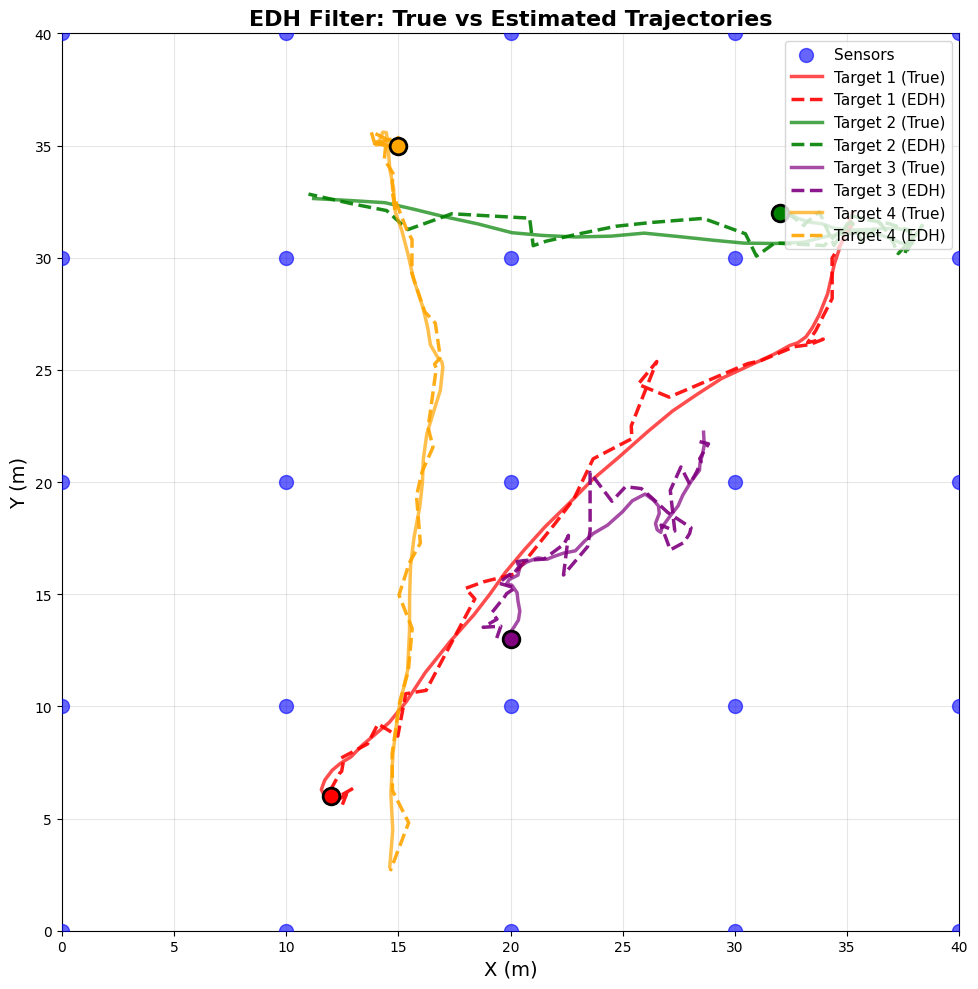

In [8]:
# Plot estimated trajectories
fig, ax = plt.subplots(figsize=(11, 10))

# Plot sensors
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()
est = edh_estimates.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (True)', alpha=0.7)
    
    # Estimates
    x_est = est[x_idx, :]
    y_est = est[y_idx, :]
    ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (EDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('EDH Filter: True vs Estimated Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

NameError: name 'edh_errors' is not defined

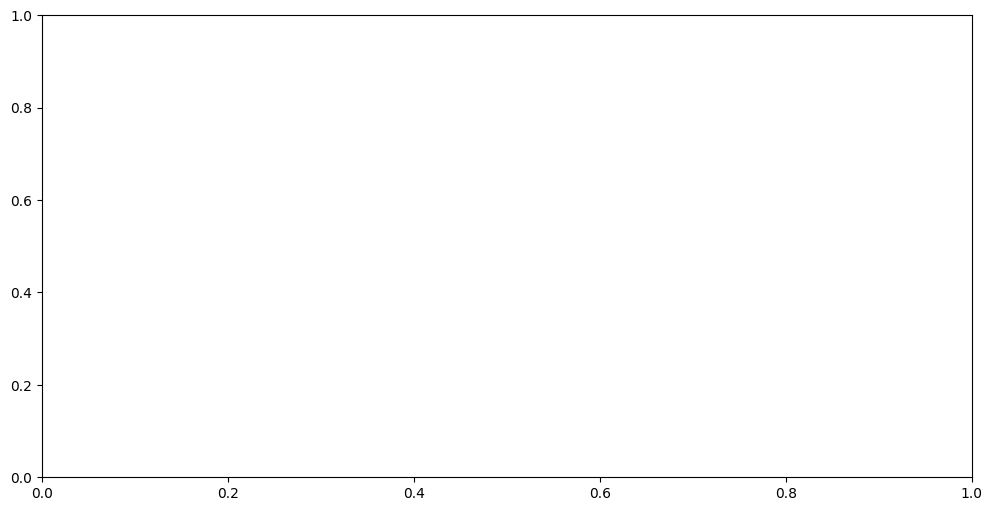

In [12]:
# Plot position errors over time
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['red', 'green', 'purple', 'orange']
time_steps = list(range(T))

errors_np = edh_errors.numpy()
for i in range(model_params['n_targets']):
    ax.plot(time_steps, errors_np[i, :], '-', color=colors[i],
           linewidth=2.5, label=f'Target {i+1}', marker='o', markersize=4)

# Mean error
mean_np = edh_mean_error.numpy()
ax.plot(time_steps, mean_np, '-k', linewidth=3,
       label='Mean Error', alpha=0.7, linestyle='dashed')

ax.set_xlabel('Time Step', fontsize=14)
ax.set_ylabel('Position Error (m)', fontsize=14)
ax.set_title('EDH Filter: Position Errors Over Time', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Algorithm Summary

### EDH Filter Algorithm (Modified Local Version)

**Initialization:**
- Draw particles $\{x_0^{(i)}\}_{i=1}^N$ from prior $p(x_0)$
- Initialize covariance $P_0$

**For each time step** $k = 1, \ldots, T$:

1. **Prediction:**
   $$x_k^{(i)} = \Phi x_{k-1}^{(i)} + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)$$

2. **Estimate covariance:**
   $$P = \frac{1}{N-1} \sum_{i=1}^N (x_k^{(i)} - \bar{x}_k)(x_k^{(i)} - \bar{x}_k)^T$$

3. **Particle flow** (for $j = 1, \ldots, N_\lambda$):
   - Set $\lambda = \lambda_j$, step size $\epsilon = \epsilon_j$
   - For each particle $i = 1, \ldots, N$:
     - Compute Jacobian: $H_i = \frac{\partial h}{\partial x}\big|_{x_k^{(i)}}$
     - Compute flow parameters:
       $$A_i = -\frac{1}{2} P H_i^T (\lambda H_i P H_i^T + R)^{-1} H_i$$
       $$b_i = (I + 2\lambda A_i)[(I + \lambda A_i) P H_i^T R^{-1} (z_k - e_i) + A_i \bar{x}_k]$$
     - Update particle: $x_k^{(i)} \leftarrow x_k^{(i)} + \epsilon (A_i x_k^{(i)} + b_i)$
   - Update mean: $\bar{x}_k = \frac{1}{N} \sum_i x_k^{(i)}$

4. **State estimate:**
   $$\hat{x}_k = \frac{1}{N} \sum_{i=1}^N x_k^{(i)}$$

### Key Differences: Original vs Modified Algorithm

| Aspect | Original (Algorithm 1) | Modified (Algorithm 2) |
|--------|------------------------|------------------------|
| Linearization | Global at $\bar{x}_k$ | Local at each $x_k^{(i)}$ |
| Flow parameters | Single $A$, $b$ for all | Individual $A_i$, $b_i$ |
| Computational cost | $O(N)$ | $O(N \cdot N_\lambda \cdot d^3)$ |
| Robustness | Good for mild nonlinearity | Excellent for strong nonlinearity |

The **local linearization** is crucial for the acoustic tracking problem because:
- Measurement function $h(x) = \sum \frac{\Psi}{r + d_0}$ is highly nonlinear
- Particles can be far from mean when spread out
- Local Jacobian $H_i$ better captures the flow at each particle location

## 11. Comparison: Original vs Modified Algorithm

In [ ]:
# Run original (global) EDH filter for comparison
print("Running original EDH filter (global linearization)...\n")
edh_filter_global = EDHFilter(
    model_params,
    n_particle=100,
    n_lambda=20,
    lambda_ratio=1.2,
    use_local=False  # Use global linearization
)

edh_estimates_global, _ = edh_filter_global.run_filter(measurements)

# Compute errors
edh_errors_global, edh_mean_error_global = compute_position_error(
    edh_estimates_global, ground_truth, model_params['n_targets']
)

rmse_global = tf.sqrt(tf.reduce_mean((edh_estimates_global - ground_truth)**2))

print("="*60)
print("Comparison: Modified (Local) vs Original (Global)")
print("="*60)
print(f"Modified RMSE: {rmse.numpy():.4f} m")
print(f"Original RMSE: {rmse_global.numpy():.4f} m")
print(f"Improvement: {((rmse_global - rmse) / rmse_global * 100).numpy():.2f}%")
print("="*60)

In [ ]:
# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

time_steps = list(range(T))
ax.plot(time_steps, edh_mean_error.numpy(), '-', color='blue',
       linewidth=3, label='Modified (Local)', marker='o', markersize=5)
ax.plot(time_steps, edh_mean_error_global.numpy(), '--', color='red',
       linewidth=3, label='Original (Global)', marker='s', markersize=5)

ax.set_xlabel('Time Step', fontsize=14)
ax.set_ylabel('Mean Position Error (m)', fontsize=14)
ax.set_title('Comparison: Modified vs Original EDH Algorithm', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observation:")
print("The modified algorithm (local linearization) performs better because:")
print("1. It linearizes at each particle location, not just at the mean")
print("2. This captures the nonlinearity more accurately")
print("3. Crucial for highly nonlinear measurement models like acoustic tracking")

## 12. Conclusion

This notebook demonstrated the **Exact Daum-Huang (EDH) filter** for multi-target acoustic tracking.

### Key Takeaways:

1. **Log-Homotopy**: EDH uses $\phi(x, \lambda) = \log g(x) + \lambda \log h(x)$ to smoothly transition from prior to posterior

2. **Exact Flow**: Particles migrate along the exact solution to the Fokker-Planck equation:
   $$\frac{\partial \phi}{\partial x} \psi + \log h = -\text{Tr}\left(\frac{\partial \psi}{\partial x}\right)$$

3. **Flow Equations**: For linear-Gaussian systems:
   $$\frac{dx}{d\lambda} = A(\lambda) x + b(\lambda)$$
   where $A$ and $b$ are derived from measurement Jacobian $H$

4. **Local vs Global**: Modified algorithm with **local linearization** at each particle is crucial for highly nonlinear problems

5. **No Resampling**: Unlike bootstrap particle filters, EDH migrates particles deterministically

6. **Performance**: EDH with 100 particles can outperform bootstrap PF with 100,000 particles on this problem

### Advantages:
- ✅ No particle degeneracy
- ✅ Works in high dimensions
- ✅ Theoretical foundation
- ✅ Deterministic (reproducible)

### Limitations:
- ⚠️ Requires computing Jacobian $H = \frac{\partial h}{\partial x}$
- ⚠️ Computational cost increases with local linearization
- ⚠️ Assumes additive Gaussian noise

### Further Reading:
- Ding & Coates (2012): Implementation details
- Daum et al. (2010): Exact flow theory
- Daum & Huang (2009): Log-homotopy foundations